In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

## EDA and Visualization 

In [28]:
# load the dataset
cars = pd.read_csv('used_cars_data.csv').drop(columns='S.No.')
cars.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


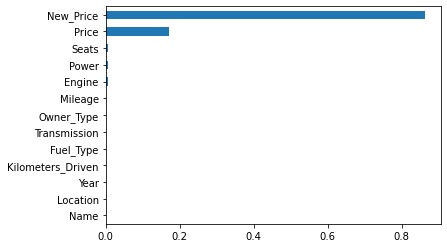

In [29]:
# check for missing values
cars.isna().mean().sort_values().plot(kind='barh');

<AxesSubplot:>

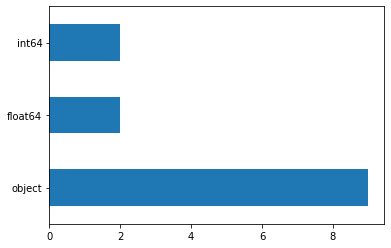

In [30]:
# check for data type in the dataset
cars.dtypes.value_counts().plot(kind='barh')

In [31]:
# cleaning the data, there are some columns which are numeric but because of unit value is reportred
# as string, we remove the units and convert them to numeric values
cars['Mileage'] = cars['Mileage'].str.replace('km/kg', '').str.replace('kmpl', '').astype(float)
cars['Engine'] = cars['Engine'].str.replace(' CC', '').astype(float)
cars['Power'] = cars['Power'].str.replace(' bhp', '').replace({'null': np.nan}). astype(float)

In [35]:
# majority of new price column is missing and we drop the entire column
# the name of vehicle does not help to create a model and it is removed
cars = cars.drop(columns=['Name', 'New_Price'])

In [36]:
cars.head()

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
0,Mumbai,2010,72000,CNG,Manual,First,26.60,998.0,58.16,5.0,1.75
1,Pune,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,12.50
2,Chennai,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,4.50
3,Chennai,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,6.00
4,Coimbatore,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,17.74


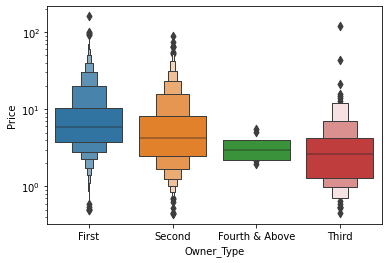

In [40]:
# distribution of price for different owner type
# log scale in y axis is used for better visualization
# price of first hand car is higher than second and third
sns.boxenplot(x='Owner_Type', y='Price', data=cars);
plt.yscale('log')

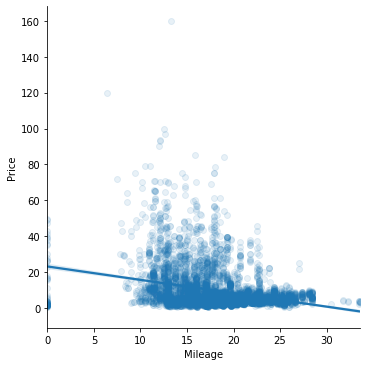

In [52]:
# price vs mileage, this chart shows that higher mileage cars tend to be cheaper
sns.lmplot(x='Mileage', y='Price', data=cars, scatter_kws={'alpha': .1});

In [45]:
# there is an outlier in driven column
cars['Kilometers_Driven'].sort_values()

1361        171
5606        600
1198       1000
5941       1000
6201       1000
         ...   
2823     480000
358      620000
1860     720000
340      775000
2328    6500000
Name: Kilometers_Driven, Length: 7253, dtype: int64

In [46]:
# remove an outlier
cars = cars.query('Kilometers_Driven < 1000000').reset_index(drop=True)

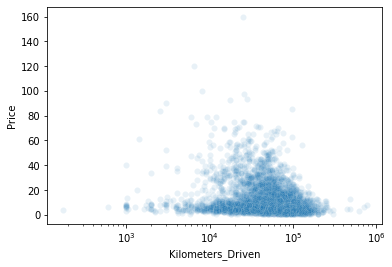

In [93]:
# scatter plot between price and kilometer driven
sns.scatterplot(x='Kilometers_Driven', y='Price', data=cars, alpha= .1);
plt.xscale('log')

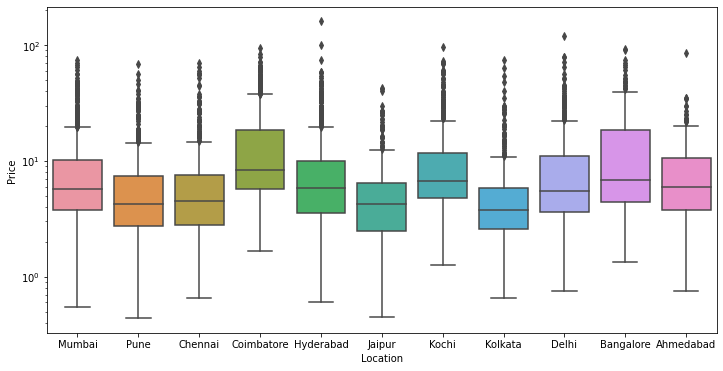

In [57]:
# distribution of price for different locations
# some locations tend to have higher price
plt.figure(figsize=(12,6))
sns.boxplot(x='Location', y='Price', data=cars);
plt.yscale('log')

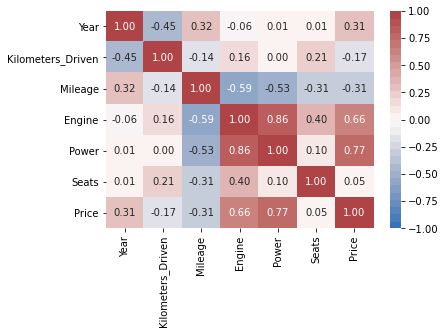

In [94]:
# correlation between price and other features
# power and engine columns are highly correlated with price
sns.heatmap(cars.corr(), vmin=-1, vmax=1, cmap=sns.color_palette('vlag', 30), annot=True, fmt='.2f');

## Modeling

In [95]:
# we remove any rows with missing price value
# missing price values cannot be replaced 
df = cars.dropna(subset=['Price']).copy()

In [96]:
# check missing values
df.isna().mean()

Location             0.000000
Year                 0.000000
Kilometers_Driven    0.000000
Fuel_Type            0.000000
Transmission         0.000000
Owner_Type           0.000000
Mileage              0.000332
Engine               0.005982
Power                0.023762
Seats                0.006979
Price                0.000000
dtype: float64

In [76]:
# replace missing values
# replace missing value with the mean of the column
df[['Mileage', 'Engine', 'Power']] = df[['Mileage', 'Engine', 'Power']].apply(lambda x: x.fillna(x.mean()))
# replace missing value with the most common value
df['Seats'] = df['Seats'].fillna(df['Seats'].mode()[0])

In [78]:
# convert categorical column to dummy variables
df = pd.get_dummies(df, drop_first=True)

In [97]:
# seperate feature set and outcome variable
X = df.drop(columns=['Price'])
y = df['Price']

In [98]:
# split the dataset into train and test group for cross-validation
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.1, random_state=123)
print(X_train.shape, X_test.shape)

(5416, 10) (602, 10)


In [82]:
# create a linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)
# calculate R2 on the test set
# our model can explain 70% of variation in price
lr.score(X_test, y_test)

0.6976461310094886

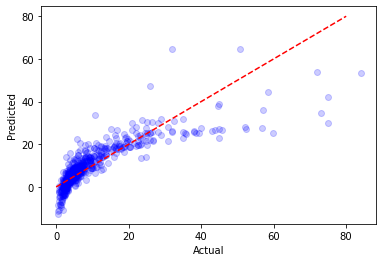

In [87]:
# plot predicted value vs value
y_pred = lr.predict(X_test)
plt.plot(y_test, y_pred, 'bo', alpha=0.2)
plt.plot([0,80], [0, 80], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted');

In [89]:
# use stats model linear regression to check feature significants
X_bias = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                  Price   R-squared (uncentered):                   0.811
Model:                            OLS   Adj. R-squared (uncentered):              0.810
Method:                 Least Squares   F-statistic:                              1072.
Date:                Thu, 20 May 2021   Prob (F-statistic):                        0.00
Time:                        19:46:20   Log-Likelihood:                         -19677.
No. Observations:                6018   AIC:                                  3.940e+04
Df Residuals:                    5994   BIC:                                  3.956e+04
Df Model:                          24                                                  
Covariance Type:            nonrobust                                                  
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------